# (1) 设置环境

In [1]:
# 导入python包
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scvelo as scv
import logging
from scipy.sparse import csr_matrix, issparse
from scipy.stats import median_abs_deviation
import leidenalg
import scvelo as scv

# 读取数据

* 读取原始数据

In [2]:
wz20d_raw = sc.read_10x_mtx("../project/wz20d/filtered_feature_bc_matrix")
wz20d_raw

AnnData object with n_obs × n_vars = 2459 × 26256
    var: 'gene_ids', 'feature_types'

* 读取质控后的数据

In [3]:
wz20d_filter = sc.read_h5ad("../data/wz20d_quality_control.h5ad")

* 读取标准化并降维聚类后的数据

In [2]:
wz20d_filter = sc.read_h5ad("../data/wz20d_normalization.h5ad")

# (2) 数据质控

## 过滤低质量的细胞

In [3]:
sc.pp.filter_genes(wz20d_raw, min_cells=3)
wz20d_raw

AnnData object with n_obs × n_vars = 2459 × 13391
    var: 'gene_ids', 'feature_types', 'n_cells'

* 看实际需要统计线粒体基因的表达情况，我这里不做统计

In [4]:
sc.pp.calculate_qc_metrics(wz20d_raw, percent_top=None, log1p=True, inplace=True)
wz20d_raw

AnnData object with n_obs × n_vars = 2459 × 13391
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

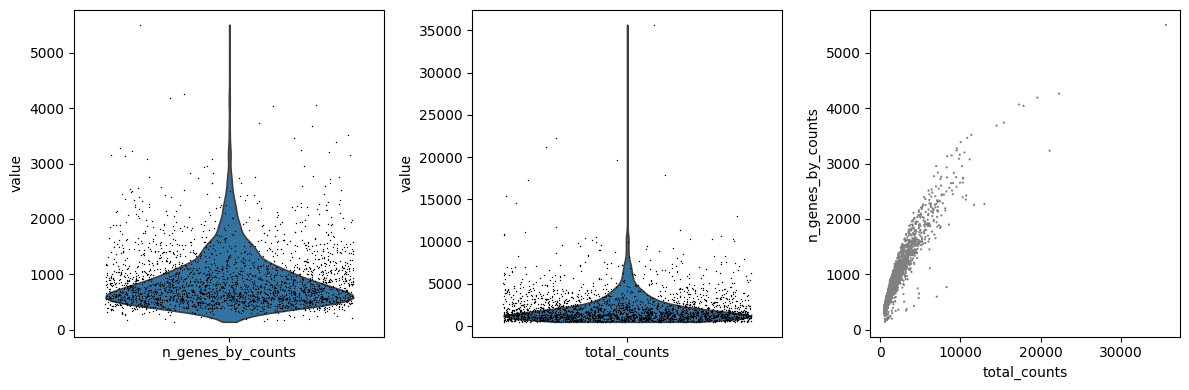

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sc.pl.violin(wz20d_raw, "n_genes_by_counts", jitter=0.4, ax=axes[0], show=False)
sc.pl.violin(wz20d_raw, "total_counts", jitter=0.4, ax=axes[1], show=False)
sc.pl.scatter(wz20d_raw, x="total_counts", y="n_genes_by_counts",size=10, ax=axes[2], show=False)
plt.tight_layout()
plt.show()

* 定义一个函数用来过滤数据

In [6]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

* 将函数应用在log1p后的数据上

In [7]:
wz20d_raw.obs["outlier"] = (
    is_outlier(wz20d_raw, "log1p_total_counts", 5)
    | is_outlier(wz20d_raw, "log1p_n_genes_by_counts", 5)
)
wz20d_raw.obs.outlier.value_counts()

outlier
False    2450
True        9
Name: count, dtype: int64

* 根据outlier列筛选数据

In [8]:
print(f"Total number of cells: {wz20d_raw.n_obs}")
wz20d_filter = wz20d_raw[(~wz20d_raw.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {wz20d_filter.n_obs}")

Total number of cells: 2459
Number of cells after filtering of low quality cells: 2450


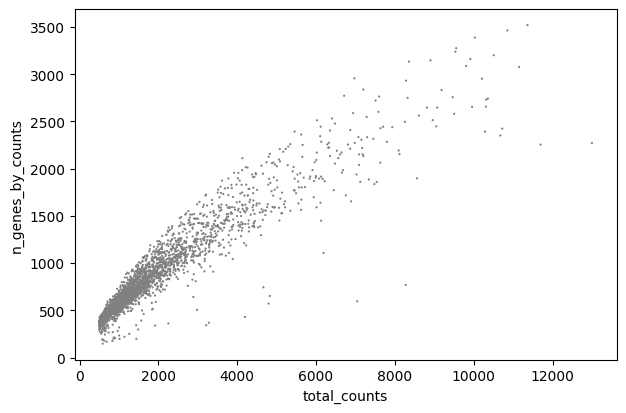

In [9]:
sc.pl.scatter(wz20d_filter, x="total_counts", y="n_genes_by_counts", size=10)

## 保存质控后的数据

In [10]:
wz20d_filter.write("../data/wz20d_quality_control.h5ad")

# (3) 标准化

## 基于 Shifted logarithm 标准化

In [11]:
# Normalize counts per cell
scales_counts = sc.pp.normalize_total(wz20d_filter, target_sum=None, inplace=False)
# log1p transform
wz20d_filter.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
wz20d_filter

AnnData object with n_obs × n_vars = 2450 × 13391
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'log1p_norm'

* 画图可视化数据标准化前和标准化后的分布情况

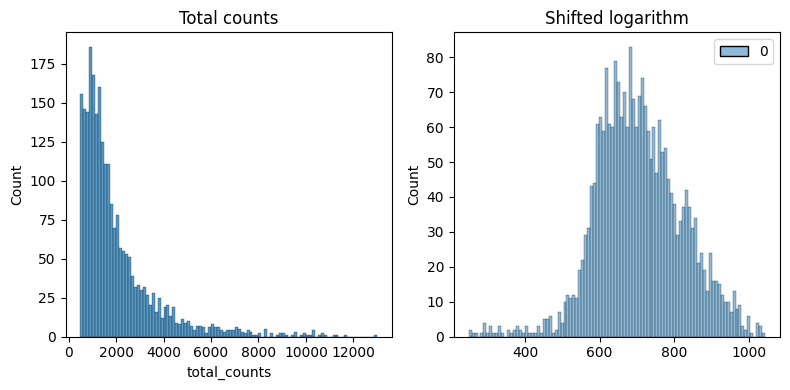

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(wz20d_filter.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(wz20d_filter.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.tight_layout()
plt.show()

# (4) 特征选择

In [13]:
sc.pp.highly_variable_genes(wz20d_filter, 
                            layer="log1p_norm",
                            flavor="cell_ranger",
                            n_top_genes=3000)

# (5) 数据降维

## PCA

* 这里替换了表达矩阵

In [14]:
# 把原始表达矩阵存到layer下，以便需要再次使用
wz20d_filter.layers["count"] = wz20d_filter.X
# 把标准化后的数据赋值给wz20d_filter.X
wz20d_filter.X = wz20d_filter.layers["log1p_norm"]
wz20d_filter

AnnData object with n_obs × n_vars = 2450 × 13391
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'log1p_norm', 'count'

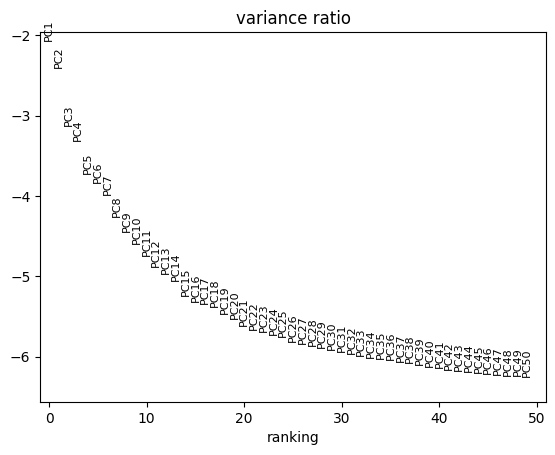

In [15]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
sc.pp.pca(wz20d_filter, svd_solver="arpack", use_highly_variable=True)
sc.pl.pca_variance_ratio(wz20d_filter, n_pcs=50, log=True)

## UMAP

In [16]:
sc.pp.neighbors(wz20d_filter, n_neighbors=15, n_pcs=50)
sc.tl.umap(wz20d_filter)

# (6) 聚类

## leiden

In [17]:
sc.tl.leiden(wz20d_filter, key_added="leiden_res0_1", resolution=0.1)
sc.tl.leiden(wz20d_filter, key_added="leiden_res0_2", resolution=0.2)
sc.tl.leiden(wz20d_filter, key_added="leiden_res0_3", resolution=0.3)
sc.tl.leiden(wz20d_filter, key_added="leiden_res0_4", resolution=0.4)
sc.tl.leiden(wz20d_filter, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(wz20d_filter, key_added="leiden_res0_6", resolution=0.6)
sc.tl.leiden(wz20d_filter, key_added="leiden_res0_7", resolution=0.7)
sc.tl.leiden(wz20d_filter, key_added="leiden_res0_8", resolution=0.8)

## 保存数据

In [19]:
wz20d_filter.write("../data/wz20d_normalization.h5ad")

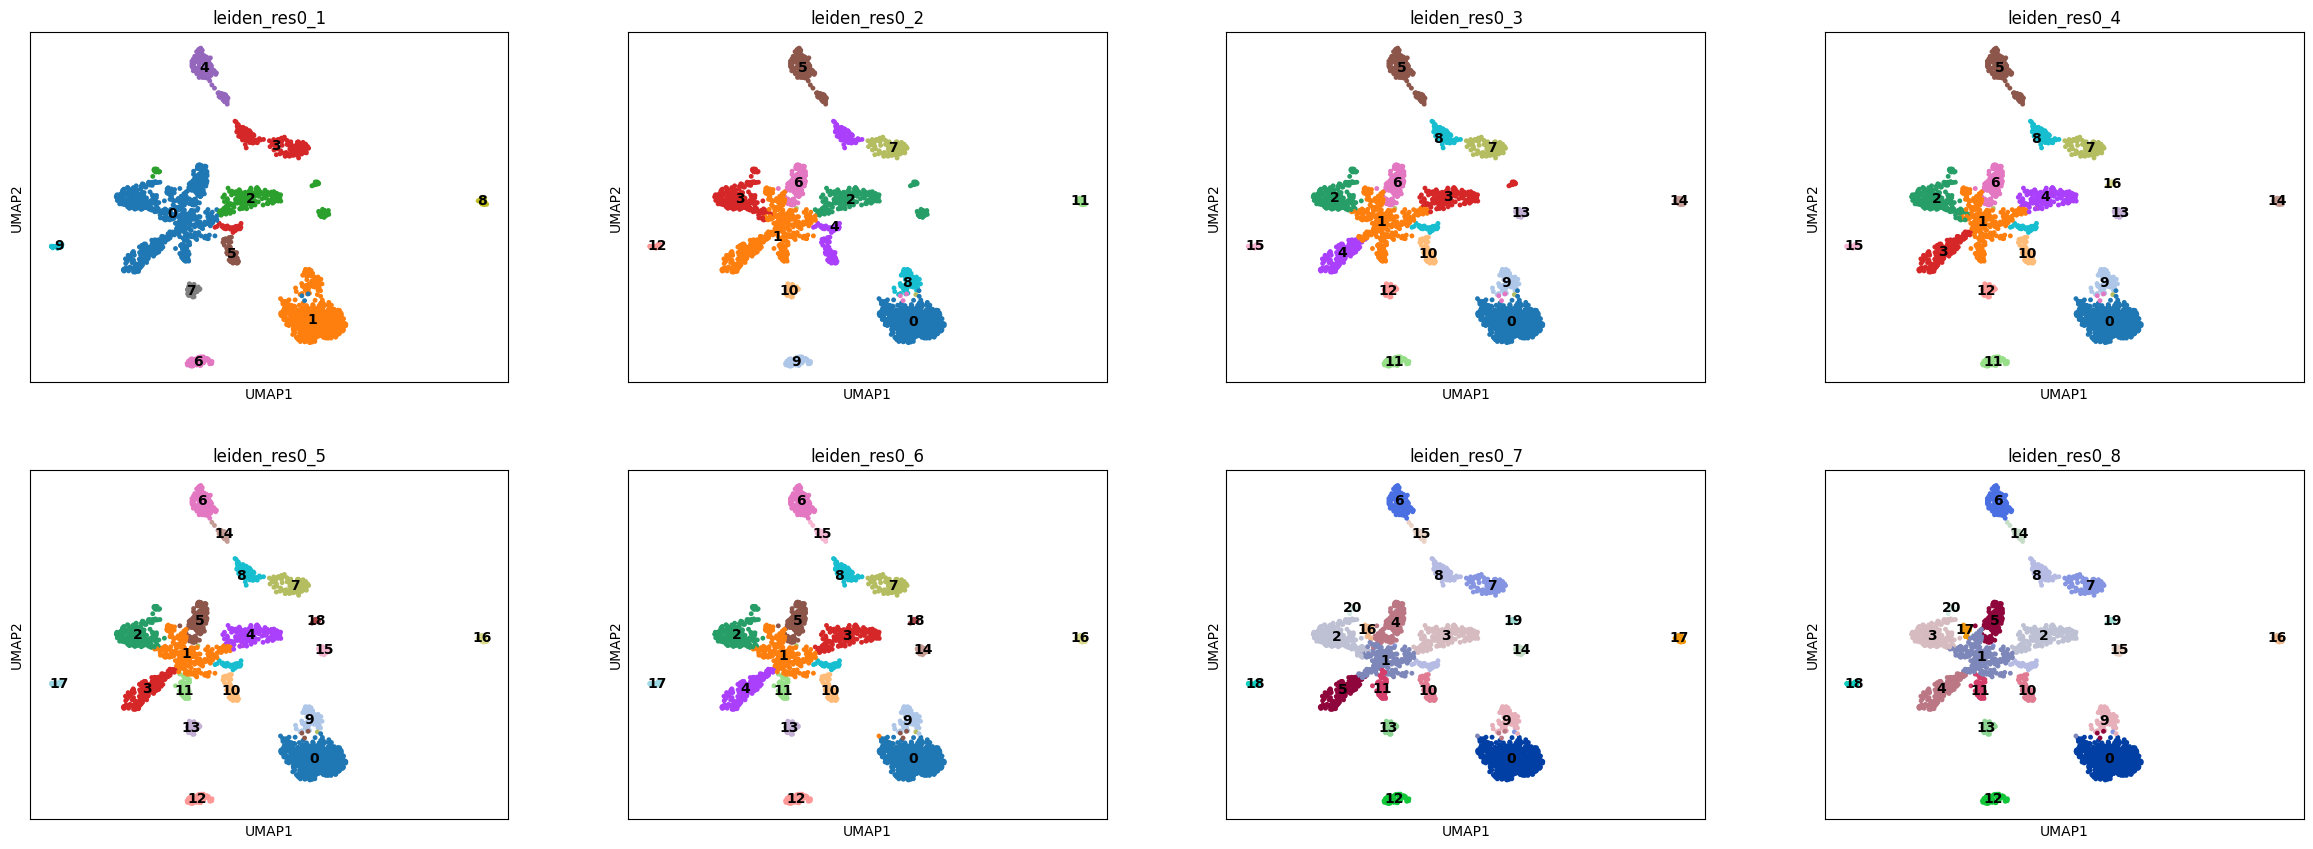

In [18]:
sc.pl.umap(
    wz20d_filter,
    color=["leiden_res0_1", "leiden_res0_2", "leiden_res0_3", "leiden_res0_4", "leiden_res0_5", "leiden_res0_6", "leiden_res0_7", "leiden_res0_8"],
    legend_loc="on data"
)

# (7) 找差异表达基因

In [32]:
sc.tl.rank_genes_groups(wz20d_filter, 
                        groupby="leiden_res0_1", 
                        method="wilcoxon", 
                        key_added="dea_leiden0_1")

In [33]:
sc.tl.filter_rank_genes_groups(
    wz20d_filter,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.5,
    key="dea_leiden0_1",
    key_added="dea_leiden0_1_filtered",
)

In [34]:
df = sc.get.rank_genes_groups_df(wz20d_filter, group=None,key="dea_leiden0_1_filtered")
df = df[df["names"].notna()]
df.to_excel('../table/scanpy_wz20d.xlsx', index=0)

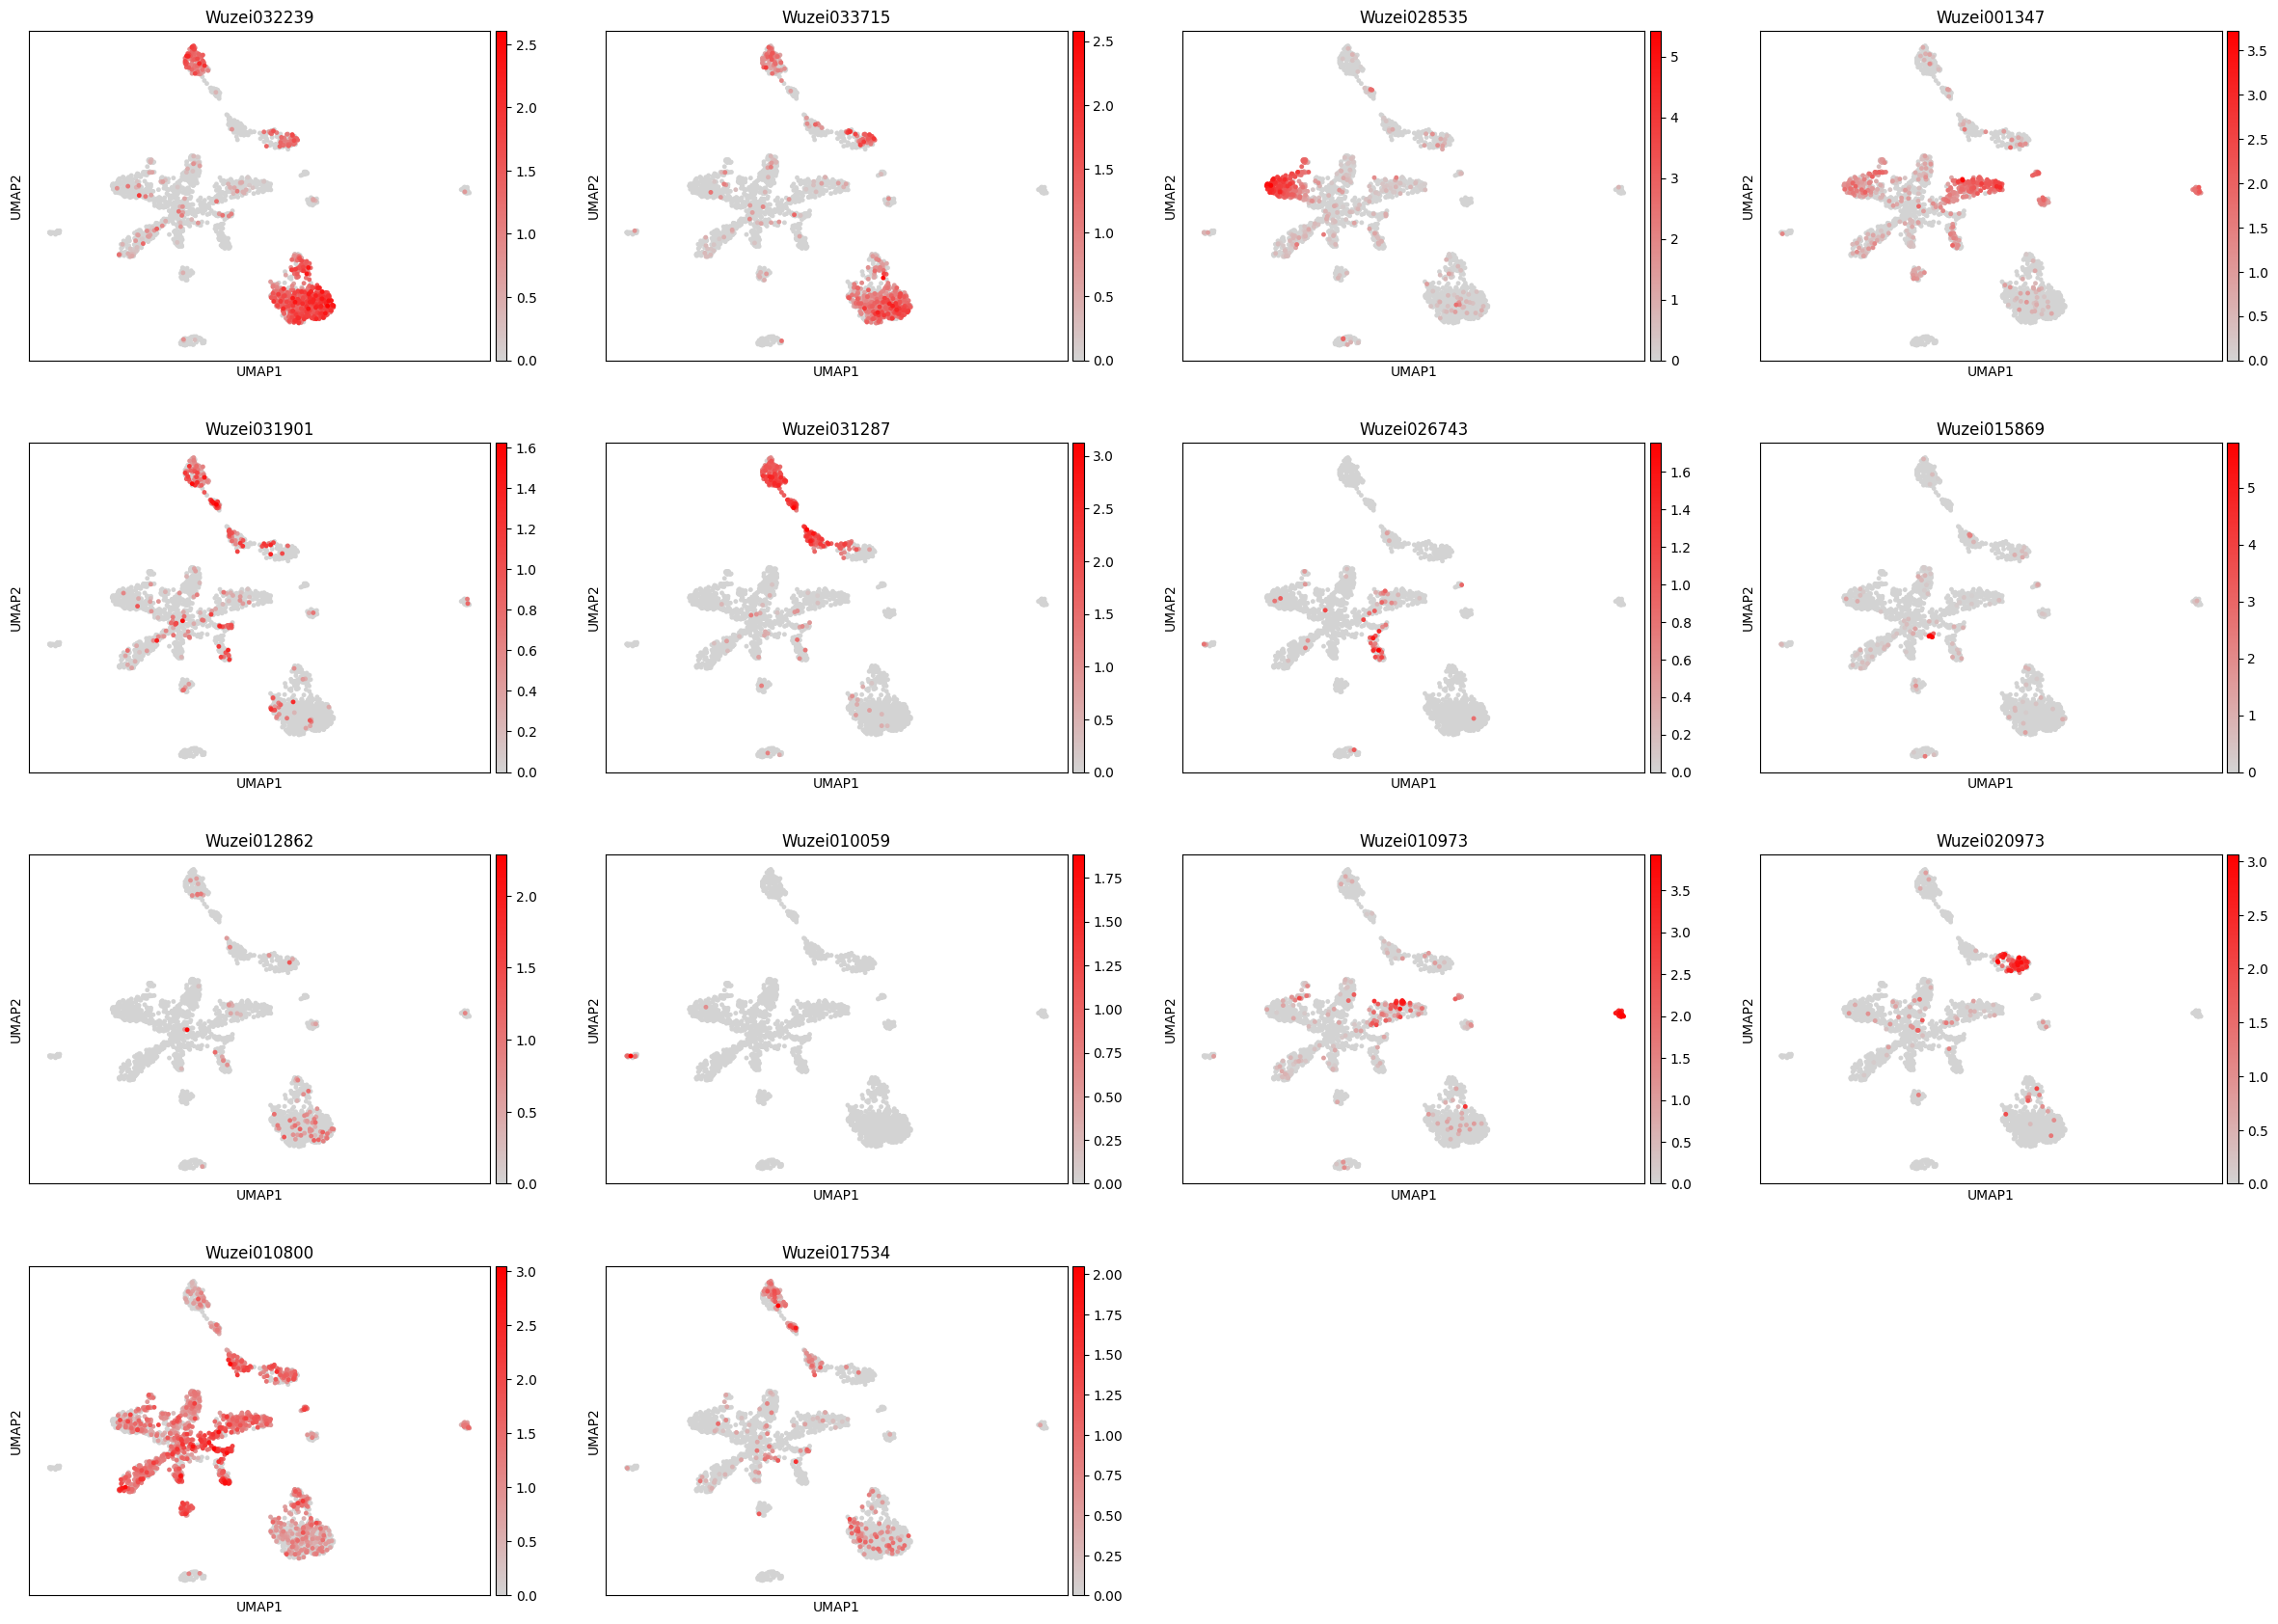

In [3]:
sc.pl.umap(wz20d_filter, color=["Wuzei032239","Wuzei033715",
                            "Wuzei028535","Wuzei001347",
                            "Wuzei031901","Wuzei031287",
                            "Wuzei026743",
                            "Wuzei015869",
                            "Wuzei012862",
                            "Wuzei010059",
                            "Wuzei010973",
                            "Wuzei020973",
                            "Wuzei010800",
                            "Wuzei017534"],
            cmap=sns.blend_palette(["lightgray","#FF0000"],as_cmap=True)
)

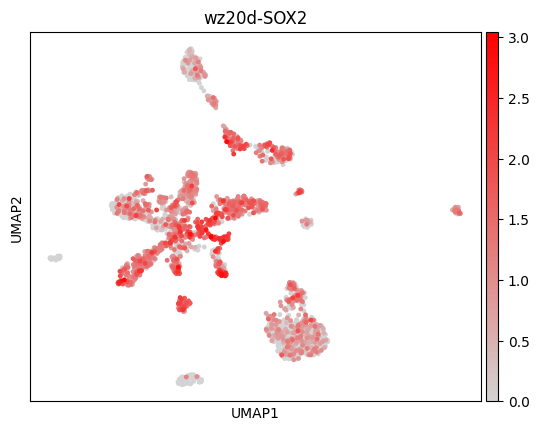

In [3]:
sc.pl.umap(wz20d_filter, color=["Wuzei010800"],
            cmap=sns.blend_palette(["lightgray","#FF0000"],as_cmap=True),
            title="wz20d-SOX2"
)

# (8) 手动对细胞类型进行注释

In [5]:
cl_annotation = {
    "0": "epidermis",
    "1":"proliferation",
    "2":"nervous system",
    "3":"Connective tissue & Muscle",
    "4":"nervous system",
}

In [6]:
color_map = {
    "epidermis":"#1F78B4",
    "limb-bud epithelium":"#A6CEE3",
    "nervous system":"#6A3D9A",
    "ZEB2+":"#CAB2D6",
    "SCO-spondin-like+":"#CB5081",
    "Smooth muscle like":"#E31A1C",
    "Connective tissue & Muscle":"#FB9A99",
    "unknow":"lightgrey",
    "proliferation":"#FF7F00",
    "reflectin+":"#FDBF6F"
}

In [7]:
wz20d_filter.obs["manual_celltype_annotation"] = wz20d_filter.obs.leiden_res0_1.map(cl_annotation)

In [ ]:
sc.pl.umap(
    wz20d_filter,
    color="manual_celltype_annotation",
    palette=color_map,
    title = "wz20d",
    legend_loc = "on data",
    legend_fontsize = 5
)

# (9) RNA速率分析

## 读取loom数据并与scanpy数据进行合并

In [2]:
wz20d_loom = scv.read("../loom/wz20d_addtag_sort_GGV25.loom")
wz20d_loom

AnnData object with n_obs × n_vars = 2459 × 26256
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

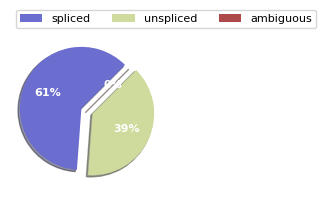

In [3]:
scv.pl.proportions(wz20d_loom)

In [3]:
# 重新读取质控后的数据
wz20d_filter = sc.read_h5ad("../data/wz20d_quality_control.h5ad")
wz20d_filter

AnnData object with n_obs × n_vars = 2450 × 13391
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [4]:
wz20d_merge = scv.utils.merge(wz20d_filter, wz20d_loom)
wz20d_merge

AnnData object with n_obs × n_vars = 2450 × 13391
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [ ]:
wz20d_merge = sc.read_h5ad("../data/wz20d_spliced.h5ad")
wz20d_merge

## 标准化

In [5]:
sc.pp.normalize_total(wz20d_merge)
sc.pp.log1p(wz20d_merge)
wz20d_merge

AnnData object with n_obs × n_vars = 2450 × 13391
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'log1p'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [6]:
sc.pp.normalize_total(wz20d_merge,layer="spliced")
sc.pp.normalize_total(wz20d_merge,layer="unspliced")
wz20d_merge

AnnData object with n_obs × n_vars = 2450 × 13391
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'log1p'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

## 鉴定高变基因

In [7]:
sc.pp.highly_variable_genes(wz20d_merge, flavor="cell_ranger", n_top_genes=3000)

## 降维

In [8]:
sc.pp.pca(wz20d_merge, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(wz20d_merge, n_neighbors=15, n_pcs=50)
sc.tl.umap(wz20d_merge)
scv.pp.moments(wz20d_merge, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 聚类

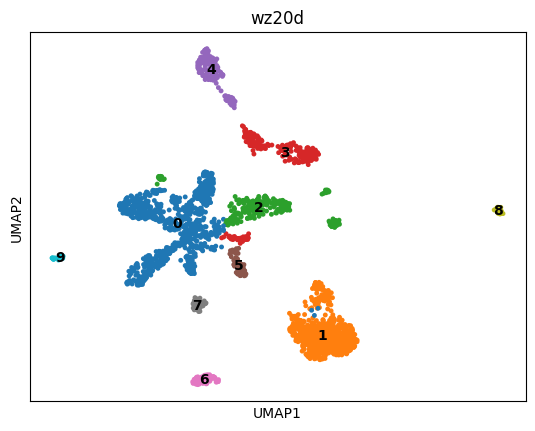

In [9]:
sc.tl.leiden(wz20d_merge, key_added="leiden_res0_1", resolution=0.1)
sc.pl.umap(wz20d_merge, color="leiden_res0_1", legend_loc="on data",title="wz20d")

In [10]:
wz20d_merge.write("../data/wz20d_spliced.h5ad")

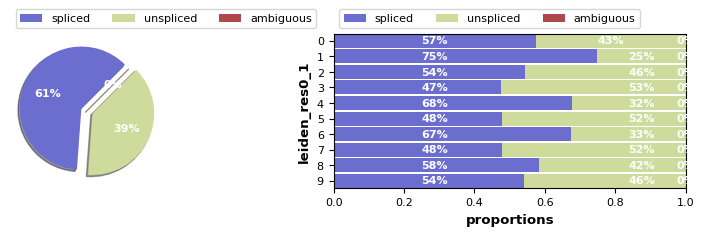

In [11]:
scv.pl.proportions(wz20d_merge, groupby="leiden_res0_1")

## 取上皮和增殖

In [10]:
wz20d_merge_sub = wz20d_merge[wz20d_merge.obs["leiden_res0_1"].isin(["1","3","4"])]
sc.pp.pca(wz20d_merge_sub, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(wz20d_merge_sub, n_neighbors=15, n_pcs=50)
sc.tl.umap(wz20d_merge_sub)
scv.pp.moments(wz20d_merge_sub, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [13]:
color_map = {
    "1":"#1f77b4",
    "3":"#ff7f0e",
    "4":"#ff7f0e"
}

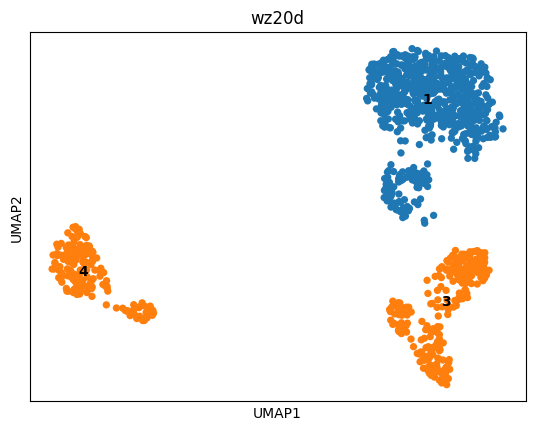

In [14]:
sc.tl.leiden(wz20d_merge_sub, key_added="leiden_res0_4", resolution=0.1)
sc.pl.umap(wz20d_merge_sub, color="leiden_res0_1", legend_loc="on data",title="wz20d",palette=color_map)

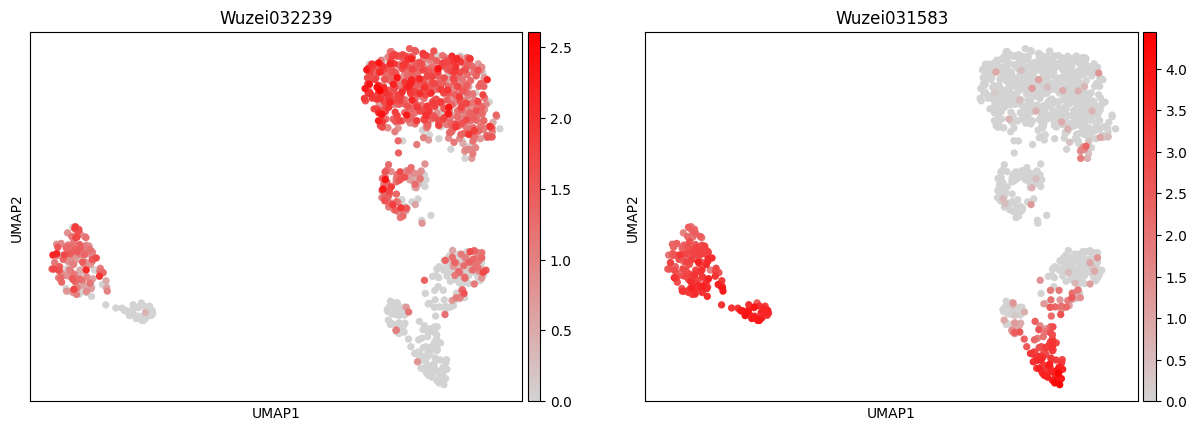

In [18]:
sc.pl.umap(wz20d_merge_sub, color=["Wuzei032239","Wuzei031583",],
            cmap=sns.blend_palette(["lightgray","#FF0000"],as_cmap=True)
)

### 计算RNA速率

In [15]:
scv.tl.velocity(wz20d_merge_sub)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [16]:
scv.tl.velocity_graph(wz20d_merge_sub)

computing velocity graph (using 1/20 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:60: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return cat(data)  # if data is categorical/array
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categoric

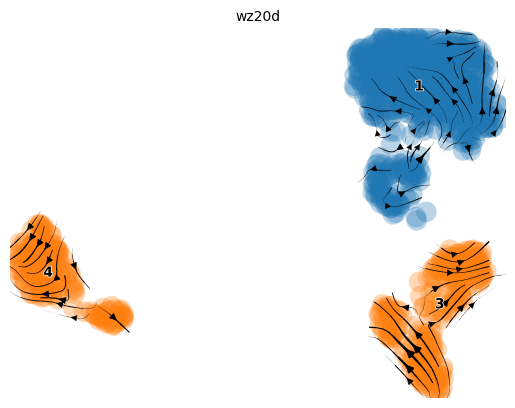

In [17]:
scv.pl.velocity_embedding_stream(wz20d_merge_sub, basis='umap', color="leiden_res0_1",title="wz20d",palette=color_map)

## 取上皮和神经

In [19]:
wz20d_merge_sub = wz20d_merge[wz20d_merge.obs["leiden_res0_1"].isin(["0","2","1"])]
sc.pp.pca(wz20d_merge_sub, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(wz20d_merge_sub, n_neighbors=15, n_pcs=50)
sc.tl.umap(wz20d_merge_sub)
scv.pp.moments(wz20d_merge_sub, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [25]:
color_map = {
    "1":"#1f77b4",
    "0":"#d62728",
    "2":"#d62728",
}

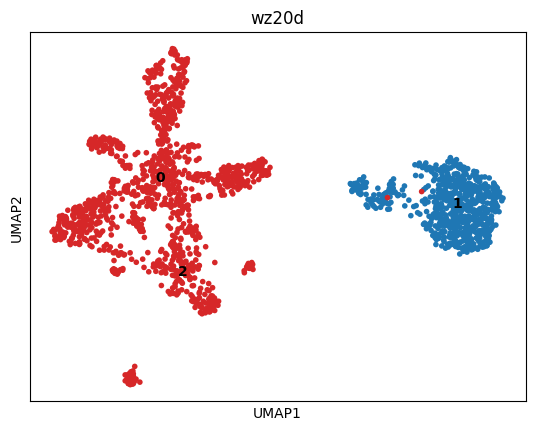

In [26]:
sc.tl.leiden(wz20d_merge_sub, key_added="leiden_res0_5", resolution=0.1)
sc.pl.umap(wz20d_merge_sub, color="leiden_res0_1", legend_loc="on data",title="wz20d",palette=color_map)

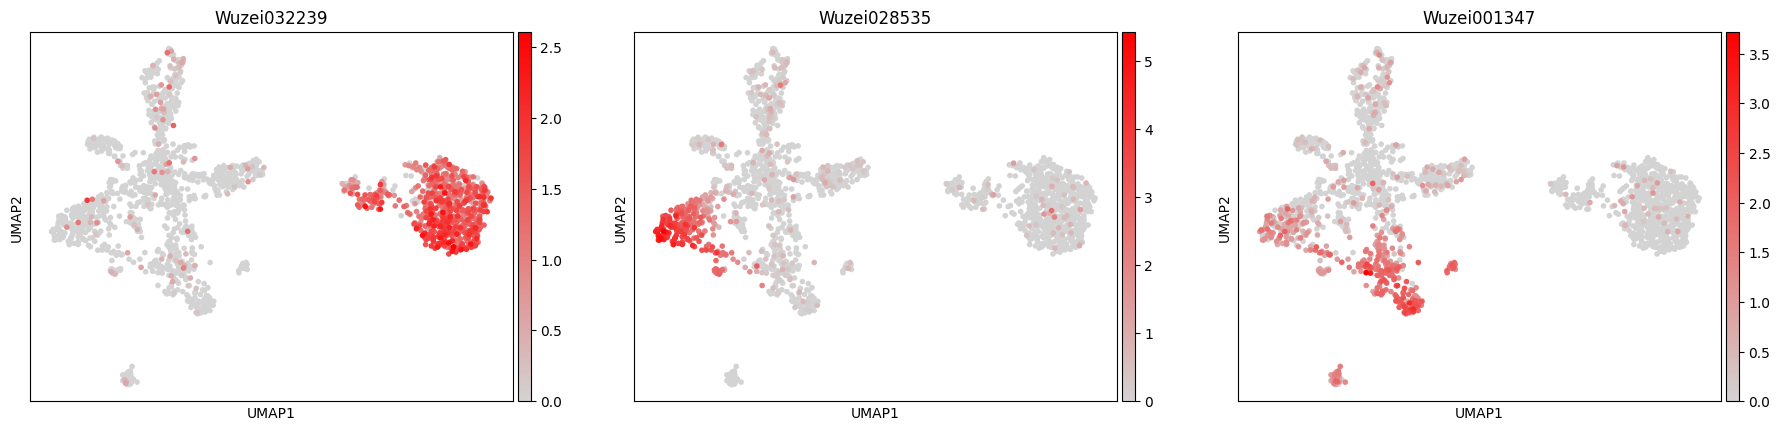

In [21]:
sc.pl.umap(wz20d_merge_sub, color=["Wuzei032239","Wuzei028535","Wuzei001347"],
            cmap=sns.blend_palette(["lightgray","#FF0000"],as_cmap=True)
)

In [22]:
scv.tl.velocity(wz20d_merge_sub)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [23]:
scv.tl.velocity_graph(wz20d_merge_sub)

computing velocity graph (using 1/20 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:60: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return cat(data)  # if data is categorical/array
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categoric

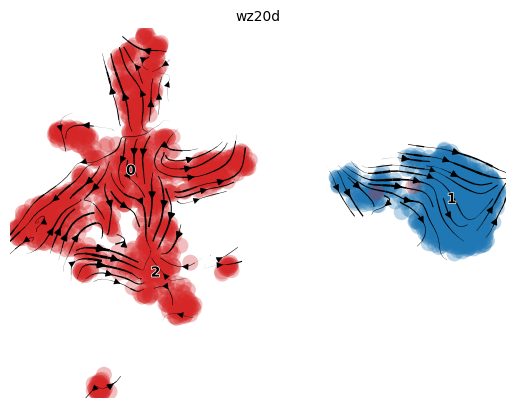

In [27]:
scv.pl.velocity_embedding_stream(wz20d_merge_sub, basis='umap', color="leiden_res0_1",title="wz20d",palette=color_map)

## 取神经和增殖

In [28]:
wz20d_merge_sub = wz20d_merge[wz20d_merge.obs["leiden_res0_1"].isin(["3","4","0","2"])]
sc.pp.pca(wz20d_merge_sub, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(wz20d_merge_sub, n_neighbors=15, n_pcs=50)
sc.tl.umap(wz20d_merge_sub)
scv.pp.moments(wz20d_merge_sub, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [36]:
color_map = {
    "3":"#ff7f0e",
    "4":"#ff7f0e",
    "0":"#d62728",
    "2":"#d62728"
}

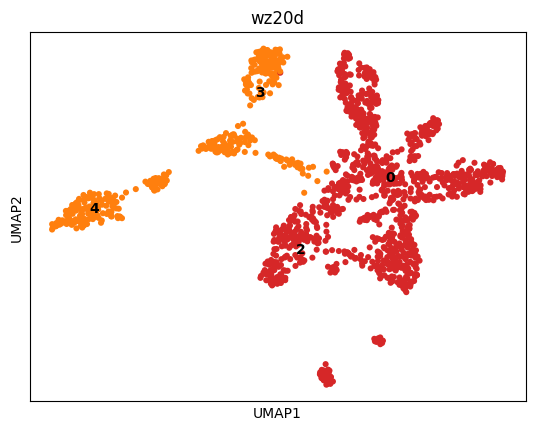

In [37]:
sc.tl.leiden(wz20d_merge_sub, key_added="leiden_res0_5", resolution=0.1)
sc.pl.umap(wz20d_merge_sub, color="leiden_res0_1", legend_loc="on data",title="wz20d",palette=color_map)

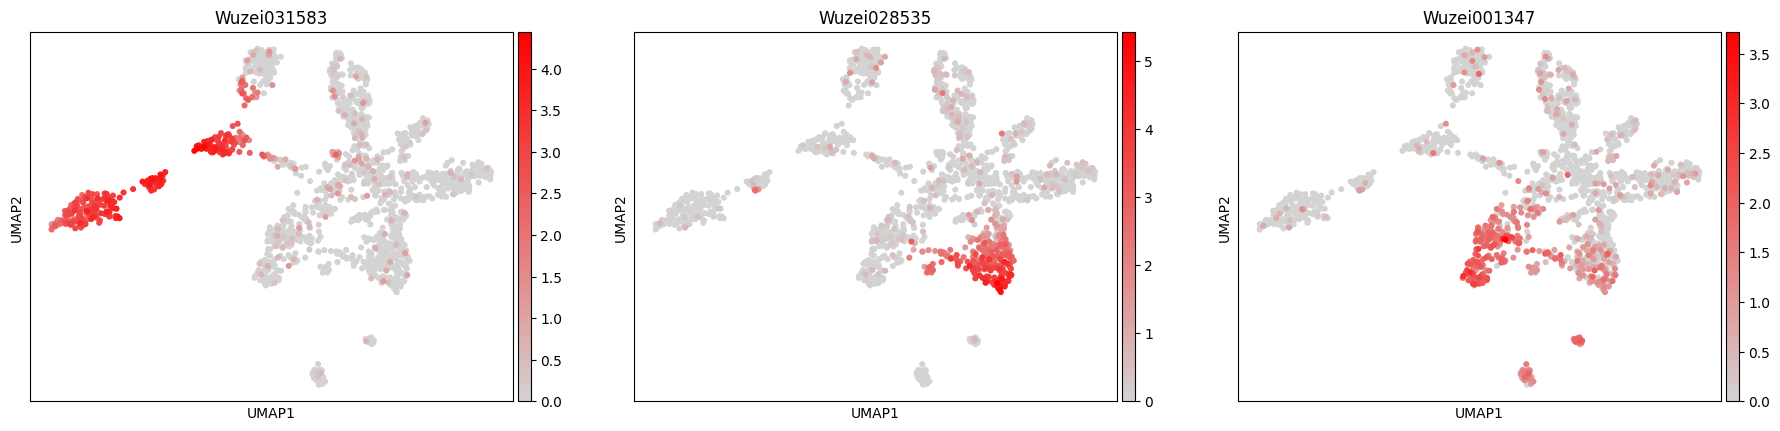

In [30]:
sc.pl.umap(wz20d_merge_sub, color=["Wuzei031583","Wuzei028535","Wuzei001347"],
            cmap=sns.blend_palette(["lightgray","#FF0000"],as_cmap=True)
)

In [31]:
scv.tl.velocity(wz20d_merge_sub)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [32]:
scv.tl.velocity_graph(wz20d_merge_sub)

computing velocity graph (using 1/20 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:60: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return cat(data)  # if data is categorical/array
c:\Users\49633\anaconda3\envs\scvi\Lib\site-packages\scvelo\plotting\utils.py:63: DeprecationWarning: is_categoric

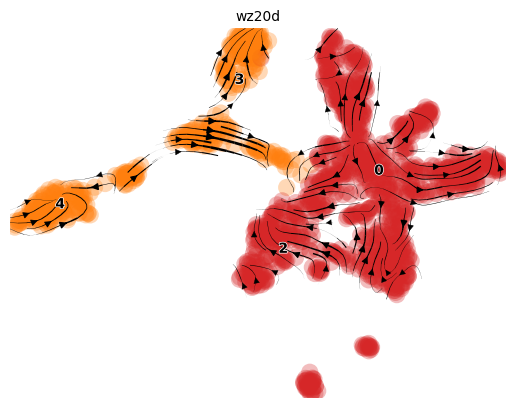

In [38]:
scv.pl.velocity_embedding_stream(wz20d_merge_sub, basis='umap', color="leiden_res0_1",title="wz20d",palette=color_map)